# Benchmarks

## Initialize

In [27]:
#library(Rmisc)
library(dtplyr)
library(tidyverse)
library(glue)
library(arrow)
library(patchwork)
library(data.table)
library("jsonlite")
library(ggthemes)

In [28]:
if (grepl("sc", Sys.info()[["nodename"]], fixed=TRUE)) {
    base_path = "/sc-projects/sc-proj-ukb-cvd"
} else {
    base_path = "/data/analysis/ag-reils/ag-reils-shared/cardioRS"}
print(base_path)

project_label = "22_retina_phewas"
project_path = glue("{base_path}/results/projects/{project_label}")
figure_path = glue("{project_path}/figures")
output_path = glue("{project_path}/data")

experiment = '220812_test'
experiment_path = glue("{output_path}/{experiment}")

[1] "/sc-projects/sc-proj-ukb-cvd"


In [29]:
base_size = 8
title_size = 10
facet_size = 9
geom_text_size=3
theme_set(theme_classic(base_size = base_size) + 
          theme(strip.background = element_blank(), plot.title=element_text(size=title_size, hjust=0), 
                strip.text.x = element_text(size = facet_size),axis.title=element_text(size=10), axis.text=element_text(size=8, color="black"),
                legend.position="bottom", axis.line = element_line(size = 0.2), axis.ticks=element_line(size=0.2), panel.grid.major.y=element_line()))

In [30]:
colors_dict = read_json("colors.json")
color_map <- c(
    "Age+Sex" = colors_dict$pastel$red$mid,
    "Retina" = colors_dict$pastel$red$mid,
    "Age+Sex+Retina" = colors_dict$pastel$red$mid,
    'MultiTaskSurvivalTraining_None_InceptionResnetV2+MLP_Identity' = colors_dict$pastel$red$mid
    #"Identity(AgeSex)+MLP" = colors_dict$pastel$red$mid,
    #"Identity(Records)+MLP" = colors_dict$pastel$red$mid,
    #"GNN(Records)+MLP" = colors_dict$pastel$red$mid,
    #"Identity(AgeSex+Records)+MLP" = colors_dict$pastel$red$mid,
    #"GNN(AgeSex+Records)+MLP" = colors_dict$pastel$red$mid
)

In [31]:
endpoint_defs = arrow::read_feather(glue("{output_path}/phecode_defs_220306.feather")) %>% arrange(endpoint)
endpoints_md = fread(glue("{experiment_path}/endpoints.csv"), colClasses=c("phecode"="character"))
endpoints = sort(endpoints_md$endpoint)

In [32]:
endpoint_map = endpoint_defs$phecode_string
names(endpoint_map) =  endpoint_defs$endpoint
endpoint_order = (endpoint_defs %>% arrange(as.numeric(phecode)))$endpoint

In [33]:
endpoint_selection = c(
    # generally very important
    "phecode_202", # Diabetes mellitus
    "phecode_404", # Ischemic heart disease
    "phecode_404-1", # Myocardial infarction [Heart attack]
    "phecode_431-11", # Cerebral infarction [Ischemic stroke]
    "phecode_424", # Heart failure
    "OMOP_4306655", # All-Cause Death
    # also generally important and relevant
    #"phecode_440-3", # Pulmonary embolism
    #"phecode_468-1",	#Viral pneumonia
    "phecode_401",	#Hypertension"
    "phecode_460-2",	#Acute lower respiratory infection
    "phecode_468", # Pneumonia
    "phecode_474", # Chronic obstructive pulmonary disease [COPD]
    "phecode_542", # Chronic liver disease and sequelae
    "phecode_583", # Chronic kidney disease
    "phecode_328", # Dementias and cerebral degeneration
    
    
    # generally important and fun to check
    "phecode_164", # Anemia
   # "phecode_726-1", # Osteoporosis
    "phecode_286-2", #	Major depressive disorder
    "phecode_103", # Malignant neoplasm of the skin
    "phecode_101", # Malignant neoplasm of the digestive organs
    #"phecode_665", # Psoriasis
    "phecode_121", # Leukemia
    "phecode_705-1", # Rheumatoid arthritis
    
    
    # important for eye
    "phecode_371", # Cataract
   # "phecode_374-3", # Retinal vascular changes and occlusions
    "phecode_374-42", # Diabetic retinopathy
    "phecode_374-5", # Macular degeneration
    "phecode_375-1" # Glaucoma
    #"phecode_388" # Blindness and low vision
)

endpoints_common = c(
   'phecode_164', #Anemia
 'phecode_705-1', #Rheumatoid arthritis
 'phecode_328', #Dementias and cerebral degeneration
 'phecode_328-1', #Alzheimer's disease
 'phecode_401', #Hypertension
 'phecode_202', #Diabetes mellitus
 'phecode_416-21', #Atrial fibrillation
 'phecode_404-1', #Myocardial infarction [Heart attack]
 'phecode_424', #Heart failure
 'phecode_468', #Pneumonia
 'phecode_474', #Chronic obstructive pulmonary disease [COPD]
 'phecode_583', #Chronic kidney disease
 'OMOP_4306655' #All-Cause Death
    )
    
endpoints_cardio = c(
    'phecode_438-11',   #  "Abdominal aortic aneurysm",
    'phecode_440-3',#  "Pulmonary embolism", # intervention
    'phecode_413-21',#  "Aortic stenosis", # intervention
    'phecode_400'#  "Rheumatic fever and chronic rheumatic heart diseases",	
)

endpoints_eye= c(
    'phecode_374-5', #Macular degeneration
 'phecode_374-51', #Age-related macular degeneration
 'phecode_374-42', #Diabetic retinopathy
 'phecode_371', #Cataract
 'phecode_388', #Blindness and low vision
 'phecode_367-5', #Uveitis
 'phecode_389-1' #Ocular pain
)

In [34]:
endpoint_defs = endpoint_defs %>% 
    mutate(name = phecode_string) %>%
    mutate(name = 
           case_when( 
               phecode_string == "Myocardial infarction [Heart attack]"~"Myocardial infarction",
               phecode_string == "Cerebral infarction [Ischemic stroke]"~"Ischemic stroke",
               phecode_string == "Chronic obstructive pulmonary disease [COPD]"~"Chronic obstructive pulmonary disease",
               phecode_string == "Mitral valve insufficiency"~"Mitral insufficiency",
               phecode_string == "Parkinson's disease (Primary)"~"Parkinson's disease",
               phecode_string == "Suicide ideation and attempt or self harm"~"Suicide attempt",
               phecode_string == "Ischemic heart disease"~"Coronary heart disease",
               phecode_string == "Chronic kidney disease"~"Chronic kidney disease",
               phecode_string == "Rheumatic fever and chronic rheumatic heart diseases"~"Rheumatic heart disease",
               phecode_string == "Abdominal aortic aneurysm"~"Abdominal aortic aneurysm",
                  TRUE ~ name)
           )
            
endpoint_map = endpoint_defs$name
names(endpoint_map) =  endpoint_defs$endpoint
#endpoint_order = (endpoint_defs %>% arrange(as.numeric(phecode)))$endpoint
endpoint_order = endpoint_selection

# Load Benchmarks

In [35]:
#today = substr(Sys.time(), 0, 10) # YYYY-MM-DD
today = '221103'
name = glue("benchmarks_cindex_{today}")
benchmark_endpoints = arrow::read_feather(glue("{experiment_path}/{name}.feather")) %>% left_join(endpoints_md) 

Joining, by = "endpoint"


In [36]:
benchmark_endpoints %>% group_by(endpoint, score) %>% summarise(cindex=mean(cindex)) %>% group_by(score) %>% summarise(mean(cindex)) %>% arrange(`mean(cindex)`)

`summarise()` has grouped output by 'endpoint'. You can override using the
`.groups` argument.


score,mean(cindex)
<chr>,<dbl>
Age+Sex,0.6043953
Retina,0.6069207
Age+Sex+Retina,0.6171583
SCORE2,0.6208000
SCORE2+Retina,0.6256793
ASCVD,0.6265802
ASCVD+Retina,0.6271062
QRISK3+Retina,0.6376704
QRISK3,0.6383278


In [37]:
endpoints_sorted = (benchmark_endpoints %>% 
    filter(score == "Age+Sex+Retina") %>% 
    group_by(endpoint, score) %>% 
    summarise(cindex=mean(cindex, na.rm=TRUE)) %>% 
    arrange(cindex) %>% ungroup())$endpoint

`summarise()` has grouped output by 'endpoint'. You can override using the
`.groups` argument.


In [38]:
categories_sorted = (endpoint_defs %>% distinct(phecode_category))$phecode_category

In [39]:
benchmark_endpoints

endpoint,score,model,iteration,time,cindex,V1,eligable,n,freq,phecode,phecode_string,phecode_category,sex,ICD10_only,phecode_top,leaf
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>
OMOP_4306655,Age+Sex,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,49,10,0.7395676,0,61256,3490,0.056974011,4306655,All-Cause Death,Death,Both,NA,NA,NA
OMOP_4306655,Retina,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,49,10,0.7442909,0,61256,3490,0.056974011,4306655,All-Cause Death,Death,Both,NA,NA,NA
OMOP_4306655,Age+Sex+Retina,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,49,10,0.7517869,0,61256,3490,0.056974011,4306655,All-Cause Death,Death,Both,NA,NA,NA
OMOP_4306655,SCORE2,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,49,10,0.7538439,0,61256,3490,0.056974011,4306655,All-Cause Death,Death,Both,NA,NA,NA
OMOP_4306655,SCORE2+Retina,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,49,10,0.7605750,0,61256,3490,0.056974011,4306655,All-Cause Death,Death,Both,NA,NA,NA
OMOP_4306655,ASCVD,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,49,10,0.7529524,0,61256,3490,0.056974011,4306655,All-Cause Death,Death,Both,NA,NA,NA
OMOP_4306655,ASCVD+Retina,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,49,10,0.7580850,0,61256,3490,0.056974011,4306655,All-Cause Death,Death,Both,NA,NA,NA
OMOP_4306655,QRISK3,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,49,10,0.7651111,0,61256,3490,0.056974011,4306655,All-Cause Death,Death,Both,NA,NA,NA
OMOP_4306655,QRISK3+Retina,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,49,10,0.7682256,0,61256,3490,0.056974011,4306655,All-Cause Death,Death,Both,NA,NA,NA


benchmark_endpoints## General Performance

In [44]:
library(ggtext)
library(ggdist)

scores_plot = c("Age+Sex", "Age+Sex+Retina")#, "AgeSexRetina")

temp = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+Retina`-`Age+Sex`) %>%
    group_by(endpoint, phecode_string, freq, phecode_category) %>%
    median_qi(delta) %>%
    mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    mutate(endpoint = fct_reorder(endpoint, delta)) %>%
    mutate(highlight = case_when(endpoint %in% endpoint_selection ~ "YES", TRUE ~ "NO")) %>%# %>% filter(endpoint %in% endpoint_sample)
    mutate(phecode_category = factor(phecode_category, levels=categories_sorted))

endpoint_order = (temp %>% arrange(delta))$endpoint
#%>% #mutate(endpoint = factor(endpoint, levels=endpoint_order)) 
temp = temp  %>% ungroup() %>% arrange(endpoint) %>% group_by(phecode_category) #%>% mutate(endpoint = row_number())

In [45]:
temp %>%  %>% head()

endpoint,phecode_string,freq,phecode_category,delta,.lower,.upper,.width,.point,.interval,pos,highlight
<fct>,<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
phecode_209-1,Pituitary hyperfunction,0.001667375,Endo,-0.6034543,-0.7690935,-0.044122726,0.95,median,qi,neg,NO
phecode_721-4,Calcium deposits in tendon and bursa,0.002287881,Musc/Skel,-0.2993190,-0.4370733,-0.047849977,0.95,median,qi,neg,NO
phecode_367-21,Corneal ulcer,0.001652703,Eye,-0.2539865,-0.4087497,-0.036825249,0.95,median,qi,neg,NO
phecode_170-19,Neutropenia NOS,0.004619467,Blood,-0.2131754,-0.3081901,-0.064206385,0.95,median,qi,neg,NO
phecode_621,Endometrial hyperplasia,0.003291957,Genitourinary,-0.1717609,-0.3741748,0.072306325,0.95,median,qi,neg,NO
phecode_179-9,Immunodeficiency NOS,0.001879484,Blood,-0.1705765,-0.3583009,-0.001694656,0.95,median,qi,neg,NO


In [47]:
benchmark_endpoints = benchmark_endpoints %>%
    filter(model == glue("ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio{crop_ratio}"))


In [56]:
x = benchmark_endpoints %>% group_by(endpoint, score) %>%
                        summarise(cindex=mean(cindex)) %>% 
                        select(endpoint, score, cindex) %>% 
                        filter(score=='Age+Sex') %>% 
                        left_join(by='endpoint', temp)
x %>% head()

`summarise()` has grouped output by 'endpoint'. You can override using the
`.groups` argument.


endpoint,score,cindex,phecode_string,freq,phecode_category,delta,.lower,.upper,.width,.point,.interval,pos,highlight
<chr>,<chr>,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
OMOP_4306655,Age+Sex,0.7428650,All-Cause Death,0.056974011,Death,0.006304892,-0.01132576,0.023608464,0.95,median,qi,pos,YES
phecode_002,Age+Sex,0.6607751,Staphylococcus,0.010796620,ID,-0.049669291,-0.09144558,-0.008650644,0.95,median,qi,neg,NO
phecode_002-1,Age+Sex,0.6522515,Staphylococcus aureus,0.007965907,ID,-0.070450138,-0.14101327,-0.015134211,0.95,median,qi,neg,NO
phecode_003,Age+Sex,0.6133523,Escherichia coli,0.015784189,ID,0.027458275,-0.01285415,0.058417084,0.95,median,qi,pos,NO
phecode_004,Age+Sex,0.5140085,Streptococcus,0.008153968,ID,-0.003166362,-0.06269310,0.067323834,0.95,median,qi,neg,NO
phecode_005,Age+Sex,0.2158769,Mycobacteria,0.001855531,ID,0.486541152,0.04988126,0.606981854,0.95,median,qi,pos,NO


In [57]:
# FREQ VS DELTA

Warning message:
“Removed 1 rows containing missing values (geom_point).”


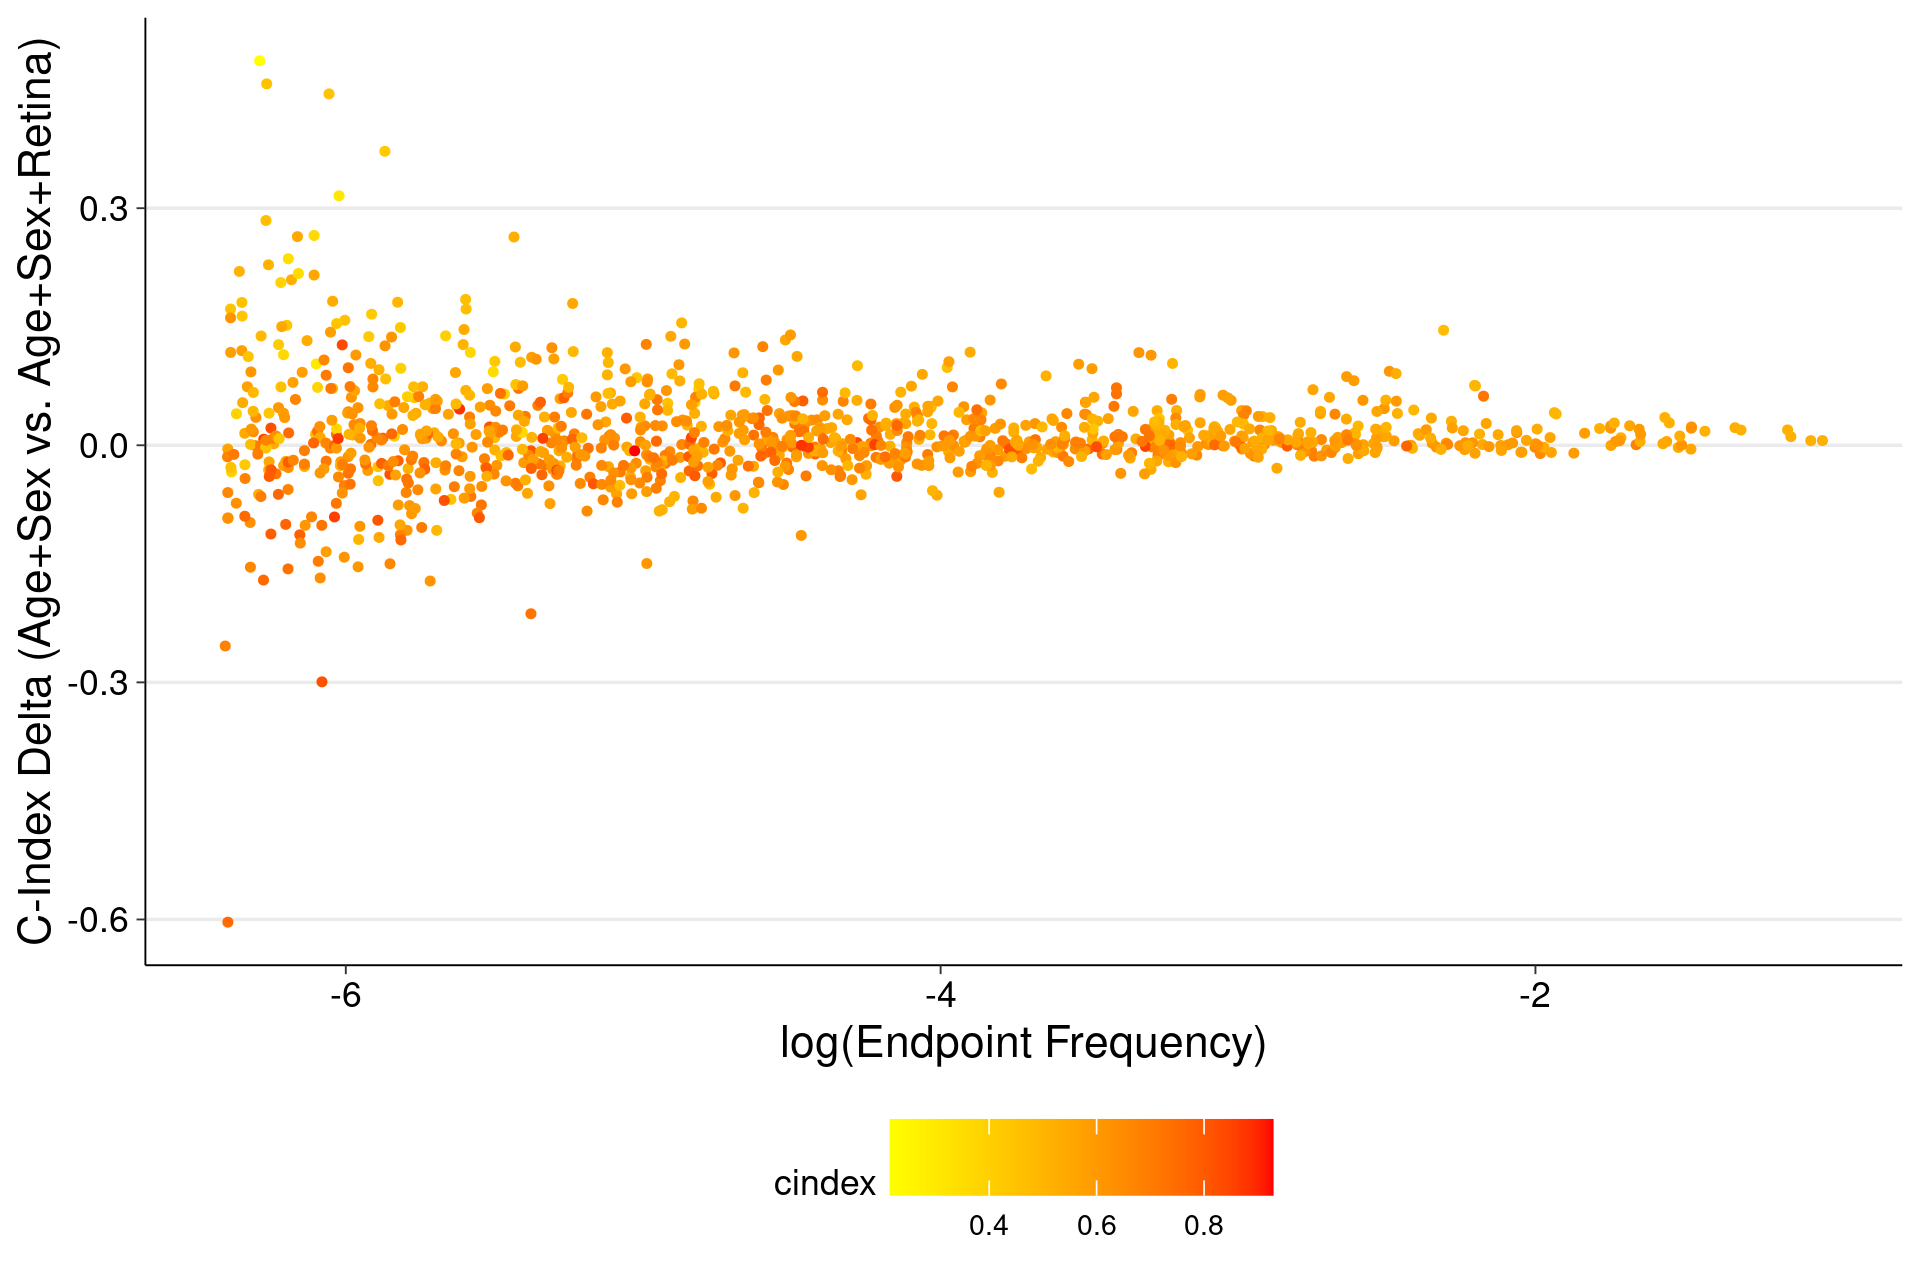

In [99]:
plot_width = 6; plot_height=4; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)

ggplot(x) +
  geom_point(aes(x=log(freq), y=delta, color=cindex), size=0.5, alpha=1) +
    scale_color_gradient(low = "yellow", high = "red") +
  labs(y="C-Index Delta (Age+Sex vs. Age+Sex+Retina)", x="log(Endpoint Frequency)")


Warning message:
“Removed 1 rows containing missing values (geom_point).”


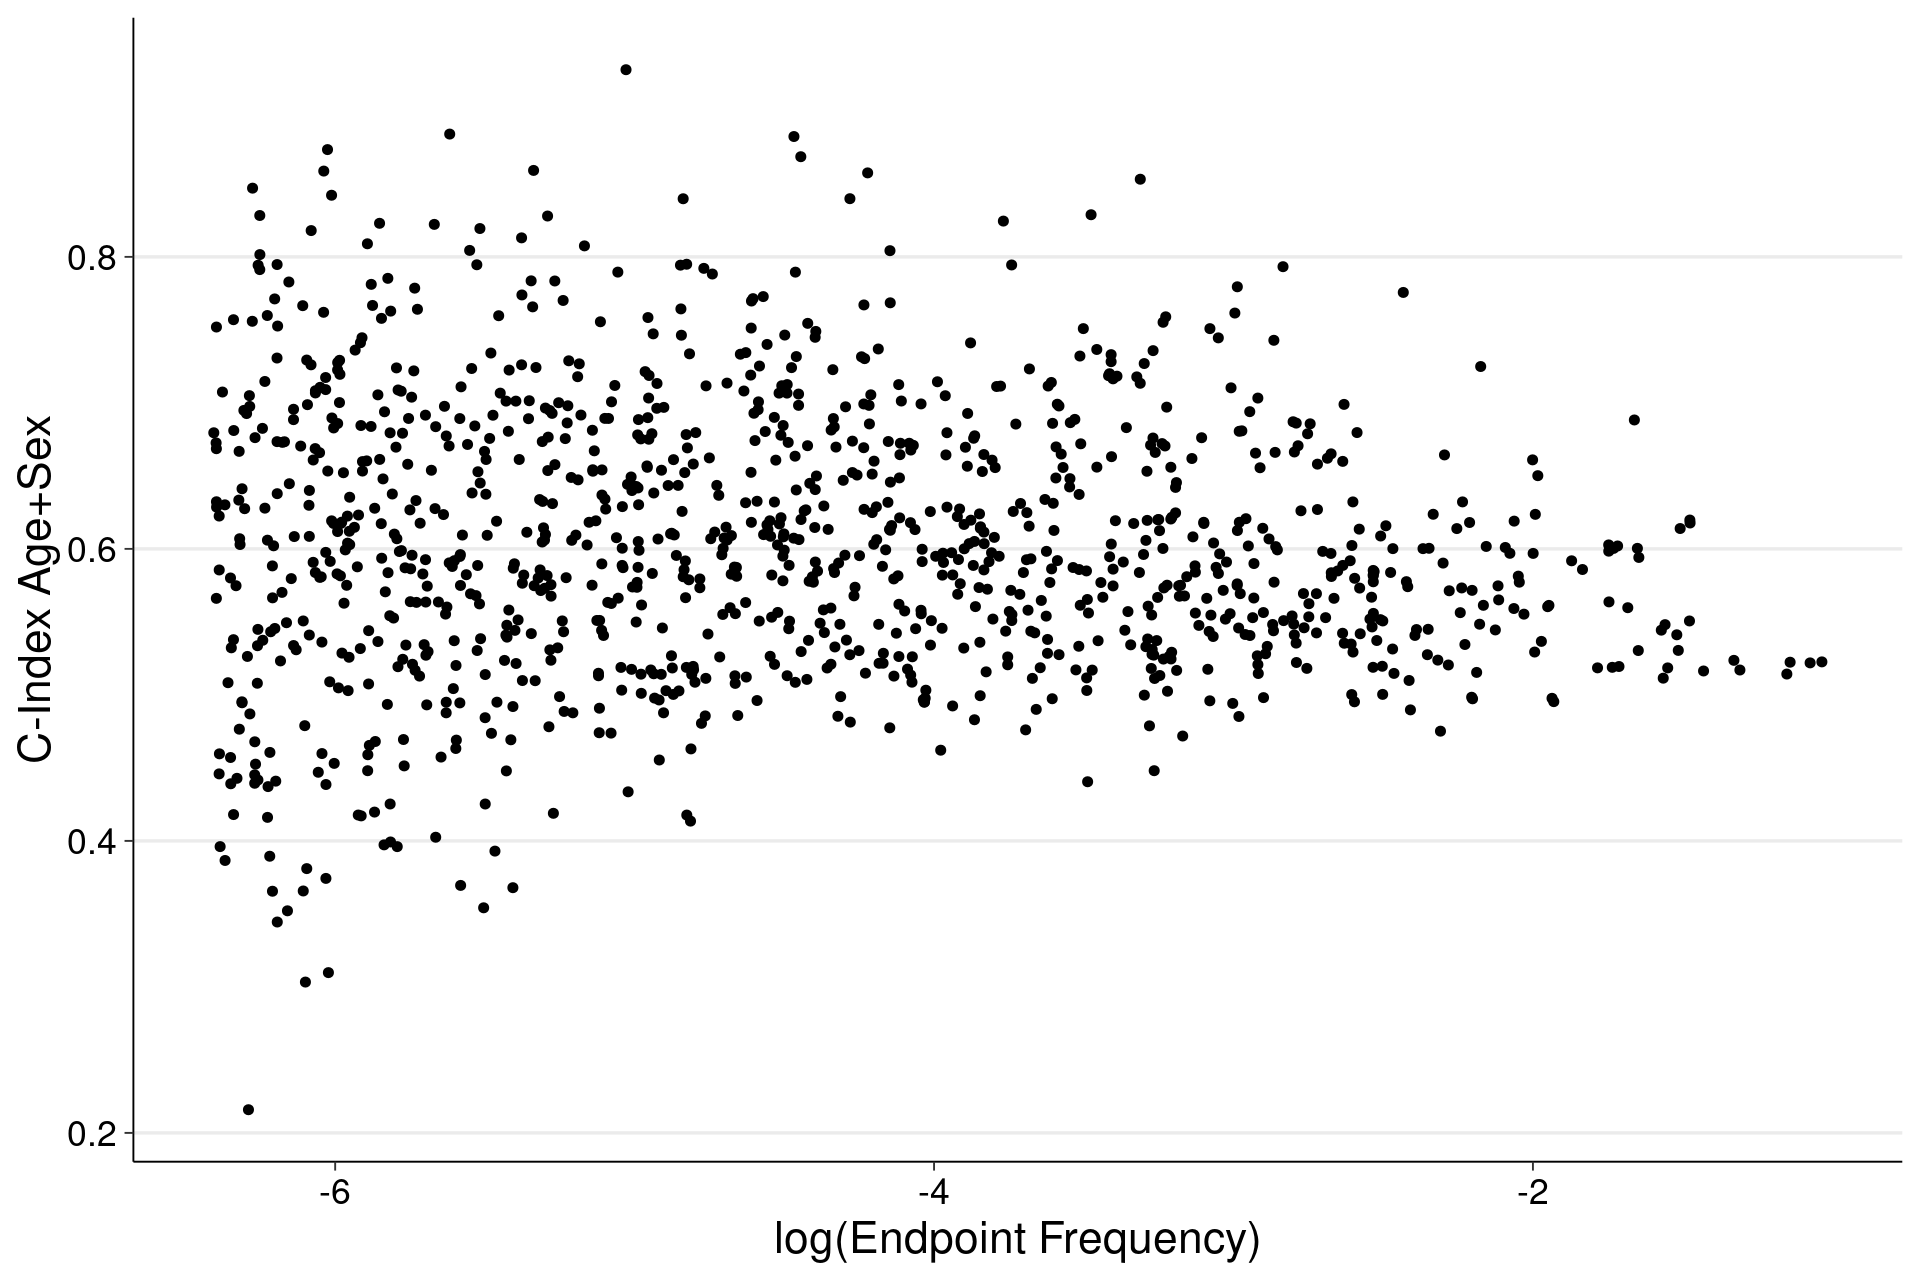

In [102]:

ggplot(x) +
  geom_point(aes(x=log(freq), y=cindex), size=0.5, alpha=1) +
#     scale_color_gradient(low = "yellow", high = "red") +
  labs(y="C-Index Age+Sex", x="log(Endpoint Frequency)")

# EID PROBLEM!


In [1]:
import pandas as pd

ERROR: Error in parse(text = x, srcfile = src): <text>:1:8: unexpected symbol
1: import pandas
           ^
